In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import gc
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Load the TensorBoard notebook extension
from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
import datetime, os
from keras.callbacks import EarlyStopping

from keras.callbacks import ReduceLROnPlateau

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
%cd /content/drive/My Drive/IDD

/content/drive/My Drive/IDD


In [0]:
from imutils import paths
from tqdm import tqdm
labels_path = paths.list_images("/content/drive/My Drive/IDD/JSON_IMG/Val_Label")
labels_path = sorted(labels_path)


import cv2
from keras.utils.np_utils import to_categorical
import numpy as np
colors = np.array([
    [0,1,0,0,0,0,0,0],      # Drivable
    [0,0,1,0,0,0,0,0],     # Non Drivable
    [0,0,0,1,0,0,0,0],      # Living Things
    [0,0,0,0,1,0,0,0],        # Vehicles
    [0,0,0,0,0,1,0,0],     # Road Side Objects
    [0,0,0,0,0,0,1,0],       # Far Objects
    [0,0,0,0,0,0,0,1],     # Sky
    [1,0,0,0,0,0,0,0]           # Misc
], dtype=np.int)

image_y_cv = []
for name in tqdm(labels_path):
  image = cv2.imread(name)
  image = cv2.resize(image, (256, 256))
  r,g,b =cv2.split(image)
  color_image = np.zeros(
        (r.shape[0], r.shape[1], 8), dtype=np.int)
  for i in range(8):
    color_image[r == i] = colors[i]
  image_y_cv.append(color_image)

from imutils import paths
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/val")
x_path = sorted(x_path)

import cv2
image_cv = []
for name in tqdm(x_path):
  image = cv2.imread(name)
  image_cv.append(cv2.resize(image, (256, 256))/255)

import numpy as np
image_cv = np.array(image_cv)
image_y_cv = np.array(image_y_cv)
image_y_cv.shape,image_cv.shape

  



Using TensorFlow backend.
100%|██████████| 1055/1055 [00:45<00:00, 23.43it/s]


((1055, 256, 256, 8), (1055, 256, 256, 3))

In [0]:
from imutils import paths
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/train")
x_path = sorted(x_path)
x_path[:5]
from imutils import paths
labels_path = paths.list_images("/content/drive/My Drive/IDD/JSON_IMG/Train_Label")
labels_path = sorted(labels_path)
#labels_path = labels_path[:2001]
labels_path[:5],x_path[:5]

(['/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0029_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0299_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame0779_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame1019_gtFine_polygons.png',
  '/content/drive/My Drive/IDD/JSON_IMG/Train_Label/201_frame1469_gtFine_polygons.png'],
 ['/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0029_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0299_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame0779_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame1019_leftImg8bit.jpg',
  '/content/drive/My Drive/IDD/leftImg8bit/train/201/frame1469_leftImg8bit.jpg'])

In [0]:
import cv2
import gc
import numpy as np
from tqdm import tqdm
colors = np.array([
    [0,1,0,0,0,0,0,0],      
    [0,0,1,0,0,0,0,0],     
    [0,0,0,1,0,0,0,0],      
    [0,0,0,0,1,0,0,0],        
    [0,0,0,0,0,1,0,0],    
    [0,0,0,0,0,0,1,0],      
    [0,0,0,0,0,0,0,1],     
    [1,0,0,0,0,0,0,0]           
], dtype=np.int)
#global block
block = 0
def train_label():
  global block
  image_y = []
  if block + 200 <= 7034:
    for name in tqdm(labels_path[block:block + 200]):
      image = cv2.imread(name)
      image = cv2.resize(image, (256, 256))
      r,g,b =cv2.split(image)
      color_image = np.zeros(
        (r.shape[0], r.shape[1], 8), dtype=np.int)
      for i in range(8):
        color_image[r == i] = colors[i]

      image_y.append(color_image)
    block = block + 200
  elif block < 7034:
      for name in labels_path[block:]:
        image = cv2.imread(name)
        image = cv2.resize(image, (256, 256))
        r,g,b =cv2.split(image)
        color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
        for i in range(8):
          color_image[r == i] = colors[i]
        image_y.append(color_image)
      block = 0
  else:
    block = 0
    for name in tqdm(labels_path[block:block + 200]):
      image = cv2.imread(name)
      image = cv2.resize(image, (256, 256))
      r,g,b =cv2.split(image)
      color_image = np.zeros((r.shape[0], r.shape[1], 8), dtype=np.int)
      for i in range(8):
        color_image[r == i] = colors[i]
      image_y.append(color_image)
    block = block + 200
  image_y = np.array(image_y)
  collected = gc.collect()  
  print("Garbage collector: collected", 
          "%d objects." % collected)
  return image_y


  


In [0]:
import cv2
block_1 = 0
def train():
  collected = gc.collect()
  print("Garbage collector: collected","%d objects." % collected) 
  global block_1
  image_tr = []
  if block_1 + 200 <= 7034:
    for name in tqdm(x_path[block_1:block_1 + 200]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255 
      image_tr.append(img)
    block_1 = block_1 + 200
  elif block_1 < 7034:
    for name in tqdm(x_path[block_1:]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255 
      image_tr.append(img)
    block_1 = 0
  else:
    block_1 = 0
    for name in tqdm(x_path[block_1:block_1 + 200]):
      image = cv2.imread(name)
      img = cv2.resize(image, (256, 256))
      img = np.float32(img)  / 255
      image_tr.append(img)
    block_1 = block_1 + 200
  image_tr = np.array(image_tr)
  return image_tr 





In [0]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
def get_small_unet(n_filters = 16, bn = True, dilation_rate = 1):
    '''Validation Image data generator
        Inputs: 
            n_filters - base convolution filters
            bn - flag to set batch normalization
            dilation_rate - convolution dilation rate
        Output: Unet keras Model
    '''
    #Define input batch shape
    batch_shape=(256,256,3)
    inputs = Input((256,256,3))
    print(inputs)
    
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
    if bn:
        conv1 = BatchNormalization()(conv1)
        
    conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv1)
    if bn:
        conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)

    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
    if bn:
        conv2 = BatchNormalization()(conv2)
        
    conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv2)
    if bn:
        conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)

    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool2)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    conv3 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv3)
    if bn:
        conv3 = BatchNormalization()(conv3)
        
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)

    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool3)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    conv4 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv4)
    if bn:
        conv4 = BatchNormalization()(conv4)
        
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)

    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool4)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    conv5 = Conv2D(n_filters * 16, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv5)
    if bn:
        conv5 = BatchNormalization()(conv5)
        
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    conv6 = Conv2D(n_filters * 8, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv6)
    if bn:
        conv6 = BatchNormalization()(conv6)
        
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    conv7 = Conv2D(n_filters * 4, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv7)
    if bn:
        conv7 = BatchNormalization()(conv7)
        
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    conv8 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv8)
    if bn:
        conv8 = BatchNormalization()(conv8)
        
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv9 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(conv9)
    if bn:
        conv9 = BatchNormalization()(conv9)
        
    conv10 = Conv2D(8, (1, 1), activation='softmax', padding = 'same', dilation_rate = dilation_rate)(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [0]:
# Load the TensorBoard notebook extension
from keras.callbacks import TensorBoard
%load_ext tensorboard
import tensorflow as tf
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard("logs", histogram_freq=1)

In [0]:
from keras.callbacks import EarlyStopping

from keras.callbacks import ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
mcp_save = ModelCheckpoint('unet_batch_norm_no_data_augument.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


In [0]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 8
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

In [0]:
model = get_small_unet(n_filters = 32)
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy',miou])
model.summary()

Tensor("input_1:0", shape=(None, 256, 256, 3), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization_1[0][0]      
______________________________

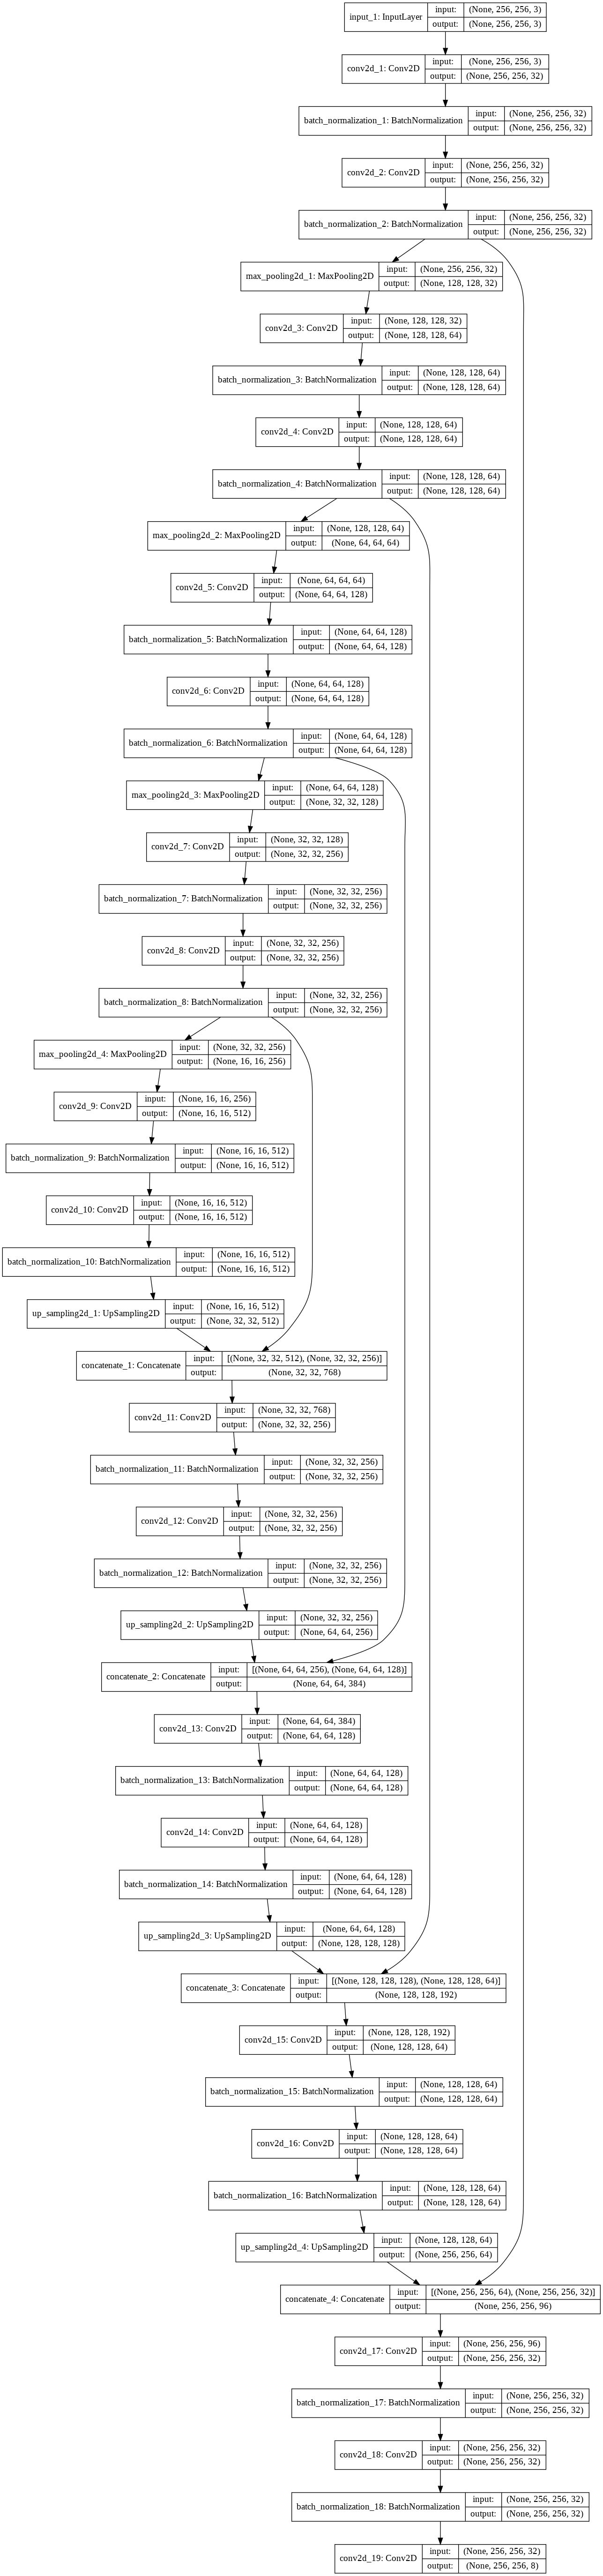

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='unet_batch_norm_no_data_augument.png', show_shapes=True, show_layer_names=True)

In [0]:
flag = 1
history_1 = []
while(flag):
  x  = train()  
  y = train_label()
  history = model.fit(x,y,batch_size=5,epochs = 3 ,callbacks=[earlyStopping, mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))
  history_1.append(history)
  flag = int(input ("Enter 0 if you want to stop training" ))
  if flag == 0:
    break


  1%|          | 2/200 [00:00<00:13, 15.12it/s]

Garbage collector: collected 15074 objects.


100%|██████████| 200/200 [00:05<00:00, 37.71it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
 95/200 [=============>................] - ETA: 24s - loss: 1.0244 - accuracy: 0.6834 - miou: 0.2554

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


200/200 [==============================] - 86s 429ms/step - loss: 0.8279 - accuracy: 0.7455 - miou: 0.2930 - val_loss: 6.9848 - val_accuracy: 0.5067 - val_miou: 0.1424
Epoch 2/3
200/200 [==============================] - 75s 375ms/step - loss: 0.5634 - accuracy: 0.8126 - miou: 0.3480 - val_loss: 8.3510 - val_accuracy: 0.3112 - val_miou: 0.0395
Epoch 3/3
200/200 [==============================] - 75s 375ms/step - loss: 0.5413 - accuracy: 0.8170 - miou: 0.3583 - val_loss: 7.7834 - val_accuracy: 0.3117 - val_miou: 0.0398
Epoch 00003: early stopping
Enter 0 if you want to stop training1


  1%|          | 2/200 [00:00<00:11, 16.88it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [00:05<00:00, 35.43it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 75s 376ms/step - loss: 0.5105 - accuracy: 0.8221 - miou: 0.3638 - val_loss: 8.7339 - val_accuracy: 0.3128 - val_miou: 0.0403
Epoch 2/3
200/200 [==============================] - 75s 373ms/step - loss: 0.5319 - accuracy: 0.8175 - miou: 0.3618 - val_loss: 6.5796 - val_accuracy: 0.3160 - val_miou: 0.0433
Epoch 3/3
200/200 [==============================] - 75s 374ms/step - loss: 0.4641 - accuracy: 0.8363 - miou: 0.3913 - val_loss: 3.7984 - val_accuracy: 0.4501 - val_miou: 0.1049
Enter 0 if you want to stop training1


  2%|▏         | 3/200 [00:00<00:08, 23.34it/s]

Garbage collector: collected 28 objects.


100%|██████████| 200/200 [01:06<00:00,  3.02it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 75s 376ms/step - loss: 0.7214 - accuracy: 0.7498 - miou: 0.3645 - val_loss: 7.0471 - val_accuracy: 0.3103 - val_miou: 0.0390
Epoch 2/3
200/200 [==============================] - 75s 373ms/step - loss: 0.6456 - accuracy: 0.7675 - miou: 0.3815 - val_loss: 5.7564 - val_accuracy: 0.3177 - val_miou: 0.0456
Epoch 3/3
200/200 [==============================] - 75s 373ms/step - loss: 0.6221 - accuracy: 0.7760 - miou: 0.3899 - val_loss: 4.9184 - val_accuracy: 0.3177 - val_miou: 0.0494
Enter 0 if you want to stop training1


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 75s 377ms/step - loss: 0.6315 - accuracy: 0.7734 - miou: 0.3719 - val_loss: 2.8191 - val_accuracy: 0.4118 - val_miou: 0.0977
Epoch 2/3
200/200 [==============================] - 75s 374ms/step - loss: 0.5829 - accuracy: 0.7847 - miou: 0.3825 - val_loss: 3.8320 - val_accuracy: 0.3825 - val_miou: 0.0865
Epoch 3/3
200/200 [==============================] - 75s 374ms/step - loss: 0.5672 - accuracy: 0.7896 - miou: 0.3871 - val_loss: 2.1479 - val_accuracy: 0.5625 - val_miou: 0.1875
Enter 0 if you want to stop training1


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 28 objects.


100%|██████████| 200/200 [00:59<00:00,  3.33it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 75s 376ms/step - loss: 0.5751 - accuracy: 0.8027 - miou: 0.3676 - val_loss: 1.7240 - val_accuracy: 0.6196 - val_miou: 0.2124
Epoch 2/3
200/200 [==============================] - 75s 375ms/step - loss: 0.5012 - accuracy: 0.8191 - miou: 0.3949 - val_loss: 1.9028 - val_accuracy: 0.5146 - val_miou: 0.1651
Epoch 3/3
200/200 [==============================] - 75s 375ms/step - loss: 0.4887 - accuracy: 0.8261 - miou: 0.4051 - val_loss: 0.8410 - val_accuracy: 0.7328 - val_miou: 0.3130
Enter 0 if you want to stop training1


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 28 objects.


100%|██████████| 200/200 [01:04<00:00,  3.08it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 75s 374ms/step - loss: 0.4881 - accuracy: 0.8199 - miou: 0.3957 - val_loss: 0.6266 - val_accuracy: 0.7759 - val_miou: 0.3611
Epoch 2/3
200/200 [==============================] - 75s 373ms/step - loss: 0.4451 - accuracy: 0.8347 - miou: 0.4138 - val_loss: 0.7006 - val_accuracy: 0.7763 - val_miou: 0.3535
Epoch 3/3
200/200 [==============================] - 75s 373ms/step - loss: 0.4347 - accuracy: 0.8383 - miou: 0.4234 - val_loss: 0.6631 - val_accuracy: 0.7740 - val_miou: 0.3488
Epoch 00003: early stopping
Enter 0 if you want to stop training1


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 75s 376ms/step - loss: 0.3794 - accuracy: 0.8649 - miou: 0.4223 - val_loss: 0.6515 - val_accuracy: 0.7777 - val_miou: 0.3402
Epoch 2/3
200/200 [==============================] - 75s 374ms/step - loss: 0.3579 - accuracy: 0.8710 - miou: 0.4334 - val_loss: 0.6265 - val_accuracy: 0.7859 - val_miou: 0.3532
Epoch 3/3
200/200 [==============================] - 75s 374ms/step - loss: 0.3547 - accuracy: 0.8728 - miou: 0.4449 - val_loss: 0.6346 - val_accuracy: 0.7901 - val_miou: 0.3556
Enter 0 if you want to stop training1


  0%|          | 0/200 [00:00<?, ?it/s]

Garbage collector: collected 37 objects.


100%|██████████| 200/200 [01:06<00:00,  2.99it/s]


Garbage collector: collected 0 objects.
Train on 200 samples, validate on 1055 samples
Epoch 1/3
200/200 [==============================] - 76s 378ms/step - loss: 0.3162 - accuracy: 0.8897 - miou: 0.4374 - val_loss: 0.8034 - val_accuracy: 0.7520 - val_miou: 0.3419
Epoch 2/3
200/200 [==============================] - 75s 376ms/step - loss: 0.2737 - accuracy: 0.9051 - miou: 0.4751 - val_loss: 0.6299 - val_accuracy: 0.7889 - val_miou: 0.3787
Epoch 3/3
200/200 [==============================] - 75s 375ms/step - loss: 0.2620 - accuracy: 0.9092 - miou: 0.4846 - val_loss: 0.6389 - val_accuracy: 0.7755 - val_miou: 0.3721
Enter 0 if you want to stop training0


In [0]:
model.save("unet_batch_norm_no_data_augument.hdf5")
print("Saved model to disk")#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#history_1 = model.fit(x  = train(),y = train_label(),batch_size=5,epochs = 100 ,callbacks=[earlyStopping, mcp_save,tensorboard_callback],validation_data=(image_cv,image_y_cv))

Saved model to disk


In [0]:
'val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_loss'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

In [0]:
loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['loss'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

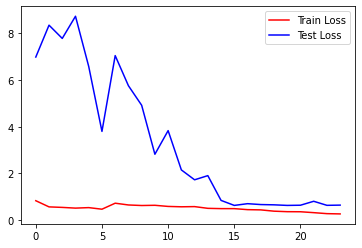

In [0]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_miou'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['miou'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

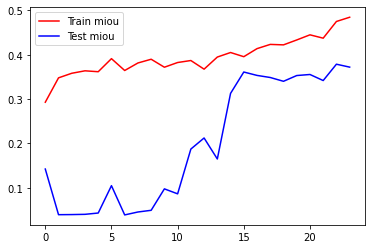

In [0]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train miou': 'r', 'Test miou':'b'})
plt.show()

In [0]:
val_loss = []
for i in range(len(history_1)):
  val_loss.append(history_1[i].history['val_accuracy'])

flat_val_loss = []
for sublist in val_loss:
    for item in sublist:
        flat_val_loss.append(item)

loss = []
for i in range(len(history_1)):
  loss.append(history_1[i].history['accuracy'])

flat_loss = []
for sublist in loss:
    for item in sublist:
        flat_loss.append(item)

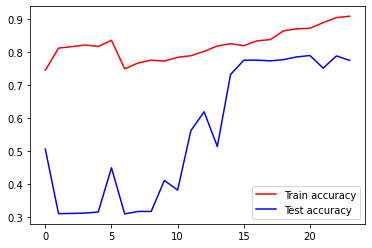

In [0]:
import matplotlib.pyplot as plt


plt.plot(flat_loss, 'r')
plt.plot(flat_val_loss, 'b')
plt.legend({'Train accuracy': 'r', 'Test accuracy':'b'})
plt.show()

In [0]:
#load model

In [0]:
x_path = paths.list_images("/content/drive/My Drive/IDD/leftImg8bit/test")
x_path = sorted(x_path)
x_path[:5]

['/content/drive/My Drive/IDD/leftImg8bit/test/200/frame0199_leftImg8bit.jpg',
 '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame0252_leftImg8bit.jpg',
 '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1090_leftImg8bit.jpg',
 '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1250_leftImg8bit.jpg',
 '/content/drive/My Drive/IDD/leftImg8bit/test/200/frame1457_leftImg8bit.jpg']

In [0]:
image_te = []
image = cv2.imread(x_path[0])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)

In [0]:
result = model.predict(image_te)

In [0]:
result = np.argmax(result, axis=3)

In [0]:
result.shape

(1, 256, 256)

In [0]:
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

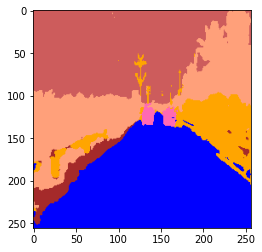

In [0]:

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


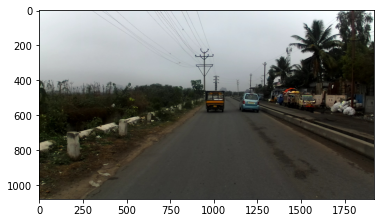

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[0])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [0]:
image_te = []
image = cv2.imread(x_path[1])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)

In [0]:
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

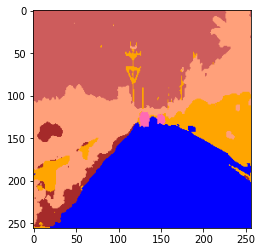

In [0]:

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


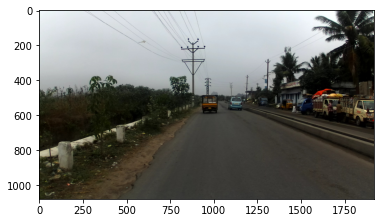

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[1])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [0]:
image_te = []
image = cv2.imread(x_path[300])
img = cv2.resize(image, (256, 256))
img = np.float32(img)  / 255 
image_te.append(img)
image_te = np.array(image_te)
result = model.predict(image_te)
result = np.argmax(result, axis=3)

In [0]:
colors = np.array([
    [255, 192 ,203	],      
    [255, 160, 122],     
    [255, 105, 180],      
    [205,  92,  92],        
    [255, 165,   0],    
    [255, 255,   0],      
    [165,  42,  42],     
    [0,   0, 255]           
], dtype=np.int)
image_y_te = []

color_image = np.zeros(
        (result.shape[1], result.shape[2], 3), dtype=np.int)
for i in range(8):
  color_image[result[0] == i] = colors[i]
image_y_te.append(color_image)
image_y_te = np.array(image_y_te)

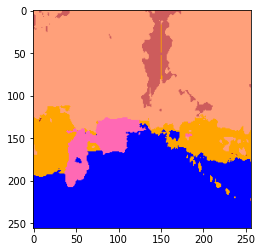

In [0]:

from matplotlib import image
from matplotlib import pyplot

pyplot.imshow(color_image)
pyplot.show()

uint8
(1080, 1920, 3)


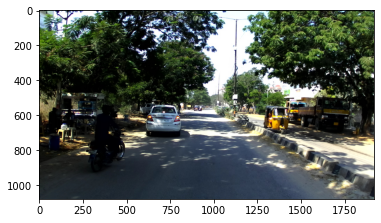

In [0]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread(x_path[300])
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()